In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as F
spark = SparkSession.builder.config("spark.driver.memory", "4g").appName("twicth").getOrCreate()
sqlContext = SQLContext(spark)

In [2]:
from pyspark.sql.functions import col, explode, array, lit
from pyspark.mllib.evaluation import MulticlassMetrics
import json
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql.types import *
schema = StructType([StructField('_id', StringType(),True),
                    StructField('_labels', StringType(), True),
                    StructField('betweenness', StringType(), True),
                    StructField('days', StringType(), True),
                    StructField('id', StringType(), True),
                    StructField('louvain', StringType(), True),
                    StructField('mature', StringType(), True),
                    StructField('node2vec', StringType(), True),
                    StructField('pageRank', StringType(), True),
                    StructField('partner', StringType(), True),
                    StructField('triangles', StringType(), True),
                    StructField('views', StringType(), True),
                    StructField('_start', StringType(), True),
                    StructField('_end', StringType(), True),
                    StructField('_type', StringType(), True)])
           

df = spark.read.format("csv").option("header",True).option("delimeter", ",")\
                        .schema(schema).load("dataset_topo.csv")

# Cleaning

In [4]:
columns_to_drop = ["_start", "_end", "_type", "_id", "_labels", "id"]
df = df.drop(*columns_to_drop)

In [5]:
numeric_features = ["betweenness", "days", "louvain", "pageRank", "triangles", "views"]
categorical_features = ["mature", "partner"]
vectorial_features = ["node2vec"]

In [6]:
for feature in numeric_features:
    df = df.withColumn(feature, col(feature).cast(DoubleType()))

In [7]:
for feature in categorical_features:
    df = df.withColumn(feature, F.when(F.col(feature) == 'True', 1).when(F.col(feature) == 'False', 0).otherwise(F.col(feature).cast(IntegerType())))

In [8]:
def parse_embedding_from_string(x):
    res = json.loads(x)
    res = [float(x_) for x_ in res]
    return res

retrieve_embedding = F.udf(parse_embedding_from_string, ArrayType(DoubleType()))

In [9]:
for feature in vectorial_features:
    df = df.withColumn(feature, retrieve_embedding(F.col(feature)))

In [10]:
print((df.count(), len(df.columns)))

(1912, 9)


In [11]:
df.printSchema()

root
 |-- betweenness: double (nullable = true)
 |-- days: double (nullable = true)
 |-- louvain: double (nullable = true)
 |-- mature: integer (nullable = true)
 |-- node2vec: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- pageRank: double (nullable = true)
 |-- partner: integer (nullable = true)
 |-- triangles: double (nullable = true)
 |-- views: double (nullable = true)



## 'count','mean','std','min','25%','50%','75%','max'

In [12]:
df.summary().select(*numeric_features).show()

+------------------+------------------+------------------+-------------------+-----------------+------------------+
|       betweenness|              days|           louvain|           pageRank|        triangles|             views|
+------------------+------------------+------------------+-------------------+-----------------+------------------+
|              1912|              1912|              1912|               1912|             1912|              1912|
| 1042.429916317991|1327.4173640167364| 679.3770920502092|0.46662358875399124|272.2437238493724| 408715.1030334728|
| 4268.853742632004| 684.8830244396679|429.97402299239377| 1.0252965829311538|812.0651466600659|3454463.3165223678|
|               0.0|             129.0|               3.0|0.15000000000000002|              0.0|               0.0|
|0.3219424071309578|             715.0|             338.0| 0.1582372710557111|              7.0|            2014.0|
| 64.92283747127675|            1314.0|             736.0|0.194856592059

In [13]:
df.summary().select(*categorical_features).show()

+-------------------+------------------+
|             mature|           partner|
+-------------------+------------------+
|               1912|              1912|
| 0.3457112970711297|0.1459205020920502|
|0.47572403857385526|0.3531188541076197|
|                  0|                 0|
|                  0|                 0|
|                  0|                 0|
|                  1|                 0|
|                  1|                 1|
+-------------------+------------------+



## Correlation Matrix

In [14]:
from pyspark.mllib.stat import Statistics
import pandas as pd


# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1]=='double']
df2=df.select(numeric_features)
print(df2)

print(compute_correlation_matrix(df2))

DataFrame[betweenness: double, days: double, louvain: double, mature: int, pageRank: double, partner: int, triangles: double, views: double]
             betweenness      days   louvain    mature  pageRank   partner  \
betweenness     1.000000  0.115797 -0.072378 -0.001572  0.295041  0.390358   
days            0.115797  1.000000 -0.076828 -0.020492  0.108065  0.176892   
louvain        -0.072378 -0.076828  1.000000 -0.016785 -0.058507 -0.096047   
mature         -0.001572 -0.020492 -0.016785  1.000000  0.007068  0.014163   
pageRank        0.295041  0.108065 -0.058507  0.007068  1.000000  0.258702   
partner         0.390358  0.176892 -0.096047  0.014163  0.258702  1.000000   
triangles       0.841594  0.118295 -0.064756  0.053071  0.394833  0.448773   
views           0.531215  0.091419 -0.034218 -0.045202  0.219702  0.272919   

             triangles     views  
betweenness   0.841594  0.531215  
days          0.118295  0.091419  
louvain      -0.064756 -0.034218  
mature        0.

## Transforming to vector

In [15]:
from pyspark.sql.functions import expr

In [16]:
arr_size = 2

df = df.select(["betweenness", "days", "louvain", "mature", "pageRank", "partner", "triangles", "views"]+[expr('node2vec[' + str(x) + ']') for x in range(arr_size)])

In [17]:
df.printSchema()

root
 |-- betweenness: double (nullable = true)
 |-- days: double (nullable = true)
 |-- louvain: double (nullable = true)
 |-- mature: integer (nullable = true)
 |-- pageRank: double (nullable = true)
 |-- partner: integer (nullable = true)
 |-- triangles: double (nullable = true)
 |-- views: double (nullable = true)
 |-- node2vec[0]: double (nullable = true)
 |-- node2vec[1]: double (nullable = true)



In [18]:
numeric_features = ["betweenness", "days", "louvain", "pageRank", "triangles", "views"]
categorical_features = ["mature", "partner"]
vectorial_features = ["node2vec"]

In [19]:
features = numeric_features + categorical_features + ["node2vec[0]", "node2vec[1]"]
features.remove("mature")

In [20]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=features, outputCol="features")
v_df = vectorAssembler.transform(df)
v_df = v_df.select(["features", "mature"])
v_df = v_df.withColumnRenamed("mature", "label")

## Oversampling

In [21]:
major_df = v_df.filter(col("label") == 0)
minor_df = v_df.filter(col("label") == 1)
ratio = int(major_df.count()/minor_df.count()) + 1
print("ratio: {}".format(ratio))

ratio: 2


In [22]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows combined_df = major_df.unionAll(oversampled_df)
combined_df = major_df.unionAll(oversampled_df)

In [23]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 1322|
|    0| 1251|
+-----+-----+



In [24]:
v_df = combined_df

In [112]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

# Results with topologic features

## Logistic Regression

In [26]:
from pyspark.ml.classification import LogisticRegression

In [106]:
lr = LogisticRegression(maxIter=1000, regParam=0.03, elasticNetParam=0.3)

In [107]:
lrModel = lr.fit(train_df)

In [108]:
predictions = lrModel.transform(test_df)

In [109]:
predictions_raw = predictions.withColumn("prediction", col("prediction")) \
                             .withColumn("label", col("label").cast(DoubleType())) \
                             .drop('features') \
                             .drop('rawPrediction') \
                             .drop('probability')

In [110]:
metrics = MulticlassMetrics(predictions_raw.rdd)

In [111]:
print("Summary Stats for LogisticRegression")
print("Accuracy = %s" % metrics.accuracy)
print("Precision = %s" % metrics.weightedPrecision)
print("Recall = %s" % metrics.weightedRecall)
print("F1 Score = %s" % metrics.weightedFMeasure())

Summary Stats for LogisticRegression
Accuracy = 0.5934640522875817
Precision = 0.5952190910622885
Recall = 0.5934640522875817
F1 Score = 0.5941143632392167


## RandomForestClassifier

In [57]:
from pyspark.ml.classification import RandomForestClassifier

In [138]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=20, numTrees=21)

In [139]:
rf_model = rf.fit(train_df)

In [140]:
rf_predictions = rf_model.transform(test_df)

In [141]:
rf_predictions_raw = rf_predictions.withColumn("prediction", col("prediction")) \
                             .withColumn("label", col("label").cast(DoubleType())) \
                             .drop('features') \
                             .drop('rawPrediction') \
                             .drop('probability')

In [142]:
rf_metrics = MulticlassMetrics(rf_predictions_raw.rdd)

In [143]:
print("Summary Stats for RandomForestClassifier")
print("Accuracy = %s" % rf_metrics.accuracy)
print("Precision = %s" % rf_metrics.weightedPrecision)
print("Recall = %s" % rf_metrics.weightedRecall)
print("F1 Score = %s" % rf_metrics.weightedFMeasure())

Summary Stats for RandomForestClassifier
Accuracy = 0.7863695937090432
Precision = 0.8160144122913595
Recall = 0.7863695937090432
F1 Score = 0.789555589571421


In [144]:
importances_features = rf_model.featureImportances.toArray().tolist()

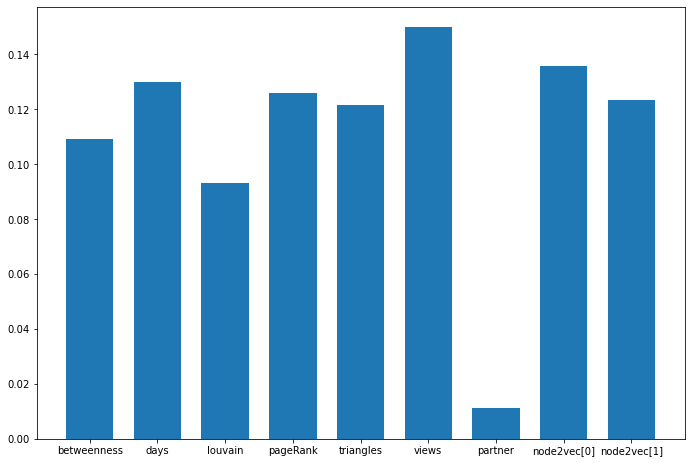

In [145]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_axes([0,0,1,1])
labels = ['betweenness','days','louvain','pageRank','triangles','views','partner','node2vec[0]','node2vec[1]']
ax.bar(labels, importances_features, width=0.7)
plt.show()

## Results without topologic features

In [42]:
df_notopo = df.select(["days", "mature", "partner", "views"])

In [43]:
vectorAssembler = VectorAssembler(inputCols=["days", "partner", "views"], outputCol="features")
v_df_notopo = vectorAssembler.transform(df_notopo)
v_df_notopo = v_df_notopo.select(["features", "mature"])
v_df_notopo = v_df_notopo.withColumnRenamed("mature", "label")

In [44]:
major_df = v_df_notopo.filter(col("label") == 0)
minor_df = v_df_notopo.filter(col("label") == 1)
ratio = int(major_df.count()/minor_df.count()) + 1
print("ratio: {}".format(ratio))

ratio: 2


In [45]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows combined_df = major_df.unionAll(oversampled_df)
combined_df = major_df.unionAll(oversampled_df)

In [46]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 1322|
|    0| 1251|
+-----+-----+



In [47]:
v_df_notopo = combined_df

In [48]:
splits = v_df_notopo.randomSplit([0.7, 0.3])
train_df_notopo = splits[0]
test_df_notop = splits[1]

In [146]:
rf_notopo = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=20, numTrees=21)
rf_notopo_model = rf_notopo.fit(train_df_notopo)
rf_notopo_predictions = rf_notopo_model.transform(test_df_notop)
rf_notopo_predictions_raw = rf_notopo_predictions.withColumn("prediction", col("prediction")) \
                             .withColumn("label", col("label").cast(DoubleType())) \
                             .drop('features') \
                             .drop('rawPrediction') \
                             .drop('probability')
rf_notopo_metrics = MulticlassMetrics(rf_notopo_predictions_raw.rdd)
print("Summary Stats for RandomForestClassifier")
print("Accuracy = %s" % rf_notopo_metrics.accuracy)
print("Precision = %s" % rf_notopo_metrics.weightedPrecision)
print("Recall = %s" % rf_notopo_metrics.weightedRecall)
print("F1 Score = %s" % rf_notopo_metrics.weightedFMeasure())

Summary Stats for RandomForestClassifier
Accuracy = 0.6060991105463787
Precision = 0.6064064594125269
Recall = 0.6060991105463787
F1 Score = 0.606217585025102


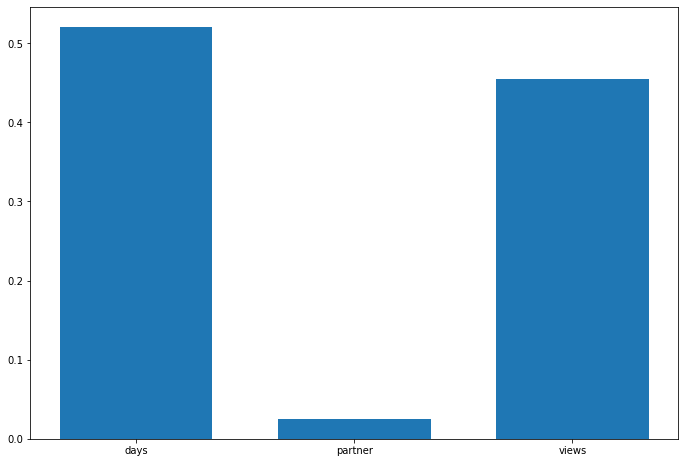

In [147]:
importances_features = rf_notopo_model.featureImportances.toArray().tolist()
fig = plt.figure(figsize=(9, 6))
ax = fig.add_axes([0,0,1,1])
labels = ["days", "partner", "views"]
ax.bar(labels, importances_features, width=0.7)
plt.show()